# **Departamento de Meteorologia - Universidade Federal do Rio de Janeiro**
---
# Trabalho de Radiação Solar e Terrestre

### Grupo:
- Dayane Andrade da Silva Bourguignon
- Felippe Galdino Silva
- Luis Alexandre Fragozo de Almeida
- Samantha Bárbara de Oliveira Cruz

### Professor: Gutemberg França

---

# 1. Objetivo:

### Avaliação sob condição de céu claro* (exemplo usar o parâmetro KT= (Radiação Global (observada na Sup.)/(Radiação solar no topo da atm)>=0,65, ver referência [1] abaixo)- o desempenho dos três Modelos Paramétricos A, B e C (Livro do Iqbal, 1983) em relação ao modelo SBDART Vs.  observações. 

# 2. Método:

    • Criação de sub-rotinas distintas para o cálculo da Radiação Direta, Difusa e Global a partir de condições iniciais da atmosfera para os modelos A, B e C;
    • Seleção de duas estações localizadas nos EUA/Canadá (em latitudes diferentes) para a validação dos modelos. Por exemplo:  Minnesota (Norte) e/ou Texas (Sul);
    • Coletar dados observados de dois anos de Radiação e os parâmetros a serem inseridos como condição inicial nos modelos (Paramétricos e SBDART);
    • Rodar os modelos e avaliar (analisando as estatísticas dos resíduos, ou seja, Estimativa - Observação, viés, correlação, média, mediana e desvio padrão) dos resultados tirando conclusões, usando dados do ano I. Caso necessário, ajustar os modelos paramétricos aos dados e compara com dados do ano II.
    ---
    • Preparar apresentação com os seguintes tópicos, a saber:
        a. Motivação do Trabalho;
        b. Objetivo;
        c. Fundamentação teórica dos modelos;
        d. Método (discorrer sobre os passos realizados incluindo a comparações...venham conversar sobre!!!);
        e. Análise dos Resultados; e
        f. Considerações Finais.
        
        
# 3. Fonte dos Dados:
https://nsrdb.nrel.gov/about/u-s-data.html

---

# Sumário

Este script está dividido em 4 partes:

1. Pré-processamento dos dados
     - Tratamento dos dados baixados do nsrdb
     - Criação do timestamp
     - Inclusão dos dias ao longo do ano (1 a 365/366)
     ---
2. Definição das Constantes, Variáveis e funções de cálculos dos parâmetros
    - Constantes definidas
    - Funções para calcular parâmetros a partir dos dados
    ---

3. Definição dos modelos A, B e C
    - Definição dos parâmetros de cada modelo
    ---
    
4. Aplicação dos modelos nos dados
    - Resultados
    - Visualizações
    

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from math import pi, cos, sin
import math
import datetime

pd.set_option("display.max_columns", None)

In [2]:
def open_nrel_file(file):
    metadata = pd.read_csv(file, nrows=1)
    dataset = pd.read_csv(file, header=2)
    
    # Criando a coluna de datetime...
    lat = metadata['Latitude'][0]
    dataset.insert(0, "date_time", pd.to_datetime(dataset[["Year","Month","Day","Hour","Minute"]]))
    day_of_year = dataset['date_time'].apply(lambda x: x.day_of_year)
    dataset.insert(1, 'day_of_year', day_of_year)
    
    
    
    return lat, dataset

In [3]:
# DADOS MIAMI

lat_miami, miami_2012_utc_time = open_nrel_file("datasets/Miami/1059495_25.77_-80.22_2012.csv")
lat_miami, miami_2013_utc_time = open_nrel_file("datasets/Miami/1059495_25.77_-80.22_2013.csv")

#######################################################################################

# DADOS NEWYORK

lat_ny, ny_2012_utc_time = open_nrel_file("datasets/NewYork/1244568_40.69_-74.02_2012.csv")
lat_ny, ny_2013_utc_time = open_nrel_file("datasets/NewYork/1244568_40.69_-74.02_2013.csv")

In [4]:
def corrige_time_UTC(dataset):
    dataset['date_time'] = dataset['date_time'] - datetime.timedelta(hours = 5)
    return dataset


miami_2012 = corrige_time_UTC(miami_2012_utc_time)
miami_2013 = corrige_time_UTC(miami_2013_utc_time)
ny_2012 = corrige_time_UTC(ny_2012_utc_time)
ny_1013 = corrige_time_UTC(ny_2013_utc_time)

In [5]:
# constantes / variáveis:
Cs = 1367 # W/m² Constante Solar
l = 0.35 # expessura camada de ozônio
Wo = 1.3 # Albedo de espalhamento simples
a = 0.25 # Albedo médio de superfície
alpha = 1.3 # Parâmetro de turbidez alfa
beta = 0.1 # Parâmetro de turbidez média
po = 1013.25 # Pressao padrão 


# Coeficiente de Transmissividade:


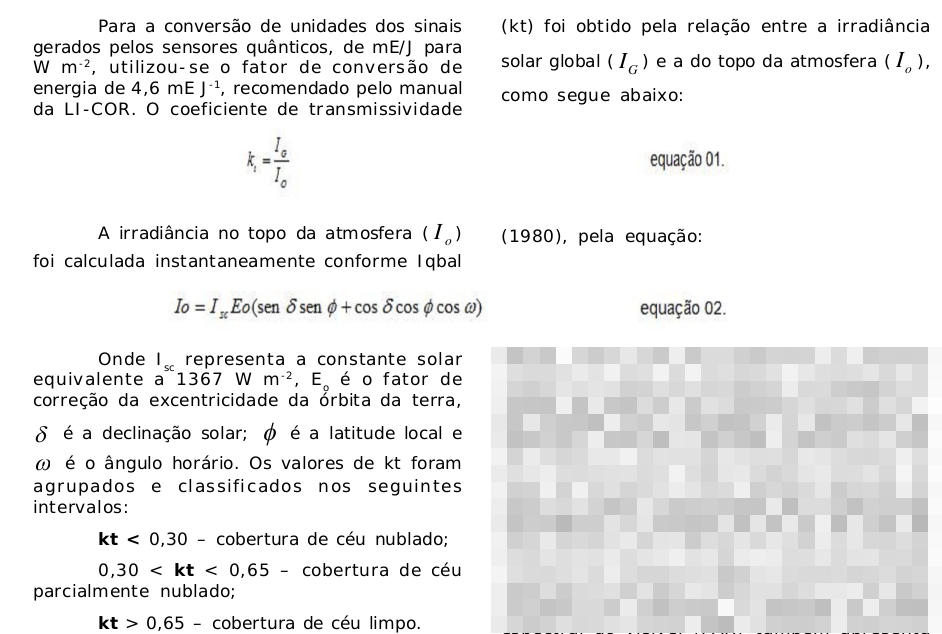

In [6]:
# Funções úteis:

# Cs = Constante Solar
# Eo = Fator de correção da excentricidade da órbita da Terra
# Ds = Declinação Solar
# lat_rad = Latitude local
# omega = Angulo Horário
def irrad_topo(Cs, Eo, Ds, lat_rad, omega):
    omega = omega * pi/180
    Io = Cs * Eo * (sin(Ds) * sin(lat_rad) + cos(Ds) * cos(lat_rad) * cos(omega))
    return Io

# Angulo Diario = Gama
def angulo_diario(dj):
    return 2*pi*(dj-1)/365

# Angulo Horario = Omega
def angulo_horario(hora):
    return (hora-12) * 15

def correcao_eo(dj):
    return 1 + 0.033*((2*pi*dj/365).apply(cos))

# Declinacao Solar = Delta
def declinacao_solar(dj):
    return 23.43 * (((360* (284+dj))/365).apply(math.radians)).apply(sin)


def angulo_zenital(delta, lat_rad, omega):
    delta = delta * pi /180
    omega = omega * pi/180
    Z = (delta.apply(sin) * sin(lat_rad) + delta.apply(cos) * cos(lat_rad) * omega.apply(cos)).apply(math.acos)
    return Z

def angulo_horario_nascer_sol(lat_rad, delta):
    delta = delta * pi /180
    Ws = (-math.tan(lat_rad) * delta.apply(math.tan)).apply(math.acos)
    return Ws

# I_sc
def radiacao_topo_atmosfera(eo, Cs, Z): # equacao 1 para radiacao topo atmosfera
    return eo * Cs * Z

def irrad_topo(Cs, Eo, Ds, lat_rad, omega): # equacao 2 para radiacao topo atmosfera
    omega = omega * pi/180
    Io = Cs * Eo * (Ds.apply(sin) * sin(lat_rad) + Ds.apply(cos) * cos(lat_rad) * omega.apply(cos))
    return Io
    
def cobertura_nuvens(rad_obs, rad_topo):
    return rad_obs/rad_topo

def celsius_to_kelvin(temp):
    return temp + 273.15

# Pressão parcial OK!
def pressao_parcial(temp_kelvin): 
    return (26.23 - 5416/temp_kelvin).apply(math.exp)

# W - Água precipitável
# Rh = Relative Humidity
# Ps = Partial pressure / pressao parcial
# T = Temp Kelvin
def agua_precipitavel(temp_kelvin, Ps, Rh):
    return (0.493 * Rh/100 * Ps)/temp_kelvin

# Massa ótica relativa - mr
def massa_otica_relativa(Z):
    return (Z.apply(cos) + 0.15*(93.885 - Z.apply(math.degrees))**-1.253)**-1
    #return (Z.apply(cos) + 0.15*(93.885 - Z)**-1.253)**-1
            
# Massa ótica absoluta - ma OK
# pa = pressao estacao
# po = pressao padrao = 1013.25
def massa_otica_absoluta(mr, pa, po):
    return mr * (pa / po)

# U1 - Caminho ótico da pressão relativa correlacionada da água precipitável OK
def caminho_otico_u1(w, mr):
    return w * mr

# U3 - Caminho ótico relativo do ozônio OK
def caminho_otico_relativo_ozonio(l, mr):
    return l * mr


    

### Água precipitável

#### Livro An Introduction to Solar , page 94

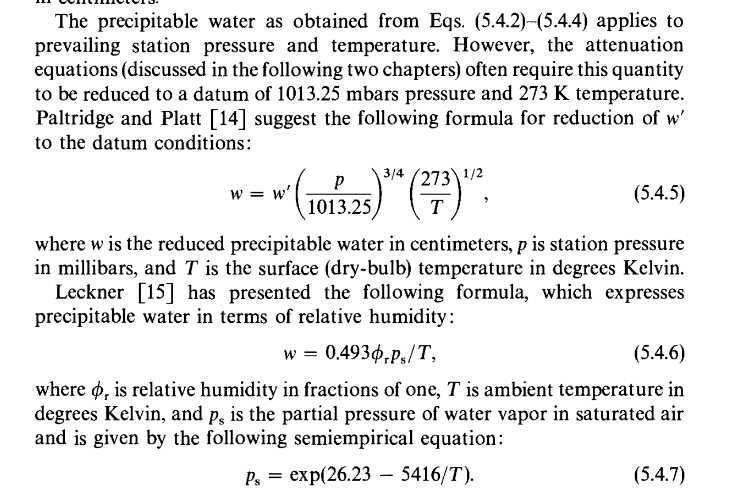

### Inserindo os parâmetros no dataset:

In [7]:
lat_rad_miami = lat_miami * pi /180
lat_rad_ny = lat_ny * pi/180

In [8]:

def insere_parametros(dataset, lat_rad, Cs):
    
    # Angulo Diario = Gama
    dataset['Gama'] =  angulo_diario(dataset['day_of_year'])

    # Angulo Horario = Omega
    dataset['Omega'] = angulo_horario(dataset['Hour'])

    # Declinacao Solar = Delta
    dataset['Delta'] = declinacao_solar(dataset['day_of_year'])

    # Correção da Excentricidade da Órbita terrestre = Eo
    dataset['Eo'] = correcao_eo(dataset['day_of_year'])

    # Temp Kelvin 
    dataset['TempKelvin'] = celsius_to_kelvin(dataset['Temperature'])

    # Pressao Parcial
    dataset['Ps'] = pressao_parcial(dataset['TempKelvin'])
    
    # dataset['Z'] = angulo_zenital(dataset['Delta'], lat_rad, dataset['Omega'])
    dataset['Z'] = dataset['Solar Zenith Angle'].apply(lambda x:  x * math.pi / 180)

    
    #dataset['I_sc'] = radiacao_topo_atmosfera(dataset['Eo'], Cs, dataset['Z'])
    dataset['I_sc'] = Cs
    
    # Radiacao Topo Atmosfera irrad_topo(Cs, Eo, Ds, lat_rad, omega):
    dataset['Io'] = irrad_topo(dataset['I_sc'], dataset['Eo'], dataset['Delta'], lat_rad, dataset['Omega'])
    
    # Kt
    dataset['kt'] = dataset['GHI']/dataset['Io']
    
    # Massa Otica Relativa
    dataset['mr'] = massa_otica_relativa(dataset['Z'])
    
    # Agua precipitavel
    dataset['W'] = agua_precipitavel(dataset['TempKelvin'], dataset['Ps'], dataset['Relative Humidity'])
    #dataset['W'] = dataset['Precipitable Water']
    
    # Caminho Otico de Pressao relativa correlacionada da água precipitável
    dataset['U1'] = caminho_otico_u1(dataset['W'], dataset['mr'])
    
    # Caminho ótico relativo do ozônio
    dataset['U3'] = caminho_otico_relativo_ozonio(l, dataset['mr'])
    
    # Massa Otica Absoluta
    dataset['ma'] = massa_otica_absoluta(dataset['mr'], dataset['Pressure'], po)
    

    return dataset

In [9]:
miami_2012_parametros = insere_parametros(miami_2012, lat_rad_miami, Cs)
ny_2012_parametros = insere_parametros(ny_2012, lat_rad_ny, Cs) 

In [10]:
miami_2012_parametros['kt'][2000:]

2000    0.000000
2001    0.000000
2002    0.000000
2003    0.027437
2004    0.379833
          ...   
8755    0.332624
8756    0.279080
8757    0.189606
8758    0.013500
8759    0.000000
Name: kt, Length: 6760, dtype: float64

---
---
# **MODELO A**
## Definição de Equações e Parâmetros

In [11]:
# MODELO A 

############################
### RADIACAO DIRETA - In ###
############################

# In = Isc * theta_a * (theta_o * theta_r - Aw)

def transmitancia_ozonio(u3):
    a = (0.02118*u3) / (1 + 0.042 * u3 + 3.23 * 10**-4 * u3**2)
    b =  (1.082 * u3) / (1 + 138.6 * u3)**0.805 
    c = (0.0658 * u3) / (1 + (103.6 * u3**2))**3
    
    return 1 - a + b + c


# Absorção do vapor de água Aw
def absorcao_vapor_agua(u1):
    return (2.9 * u1)/((1 + 141.5 * u1)**0.635 + 5.925*u1)

# Absortância do espalhamento de Rayleigh - theta_r
def absorcao_espalhamento_rayleigh(ma):
    return (0.972 - 0.08262 * ma + 0.00933 * ma**2 - 0.00095 * ma**3 + 0.000437 * ma**4)


###################################################

# Absorcao dos aerosois - theta_a EQUACAO 1 = theta_a
def absorcao_aerosois1(vis, ma):
    
    theta_a = (0.97 - 1.265*(vis)**-0.66)**ma**0.9
    return theta_a
    
# Absorcao dos aerosois - theta_a EQUACAO 2 = theta_a
def absorcao_aerosois2(alpha, beta, ma):
    
    theta_a = (0.12445 * alpha - 0.0162) + (1.003 - 0.125*alpha) * (-beta*ma*(1.0892* alpha +0.5123)).apply(math.exp)
    return theta_a


def albedo_atmosferico(theta_a, Wo):
    rho_a = 0.0685 + 0.17*(1 - theta_a)*Wo
    return rho_a


def radiacao_direta(I_sc, theta_a, theta_o, theta_r, aw):
    
    In = I_sc * theta_a * (theta_o * theta_r - aw)
    return In
###################################################

#######################
### RADIACAO DIFUSA ###
#######################


# Difusa Rayleigh - I_dr

def difusa_rayleigh(I_sc, Z, theta_o, theta_r, theta_a):
    
    I_dr = I_sc * Z.apply(cos) * theta_o * (0.5 * (1 - theta_r)) * theta_a
    return I_dr


# Difusa Aerosois - I_da

def difusa_aerosois(I_sc, Z, theta_o, theta_r, theta_a, Aw, Fc, Wo):

    return (I_sc * Z.apply(cos) * (theta_o * theta_r - Aw) * (Fc * Wo * (1 - theta_a)))
                                                                             
                                                                    
# Difusa Espalhamento Múltiplos
def difusa_multiplos(In, Z, I_dr, I_da, rho_a, rho_g):
    I_dm = ((In * Z.apply(cos) + I_dr + I_da) * rho_g * rho_a) / 1 - rho_g * rho_a
    return I_dm


    


                                                                             
                                                                

    

In [12]:
import datetime 

date_winter_min = datetime.datetime(2012,1,9,0,0)
date_winter_max = datetime.datetime(2012,1,10,0,0)

date_summer_min = datetime.datetime(2012,7,9,0,0)
date_summer_max = datetime.datetime(2012,7,10,0,0)


# MIAMI
miami_summer = miami_2012_parametros[(miami_2012_parametros['date_time']>=date_summer_min) & (miami_2012_parametros['date_time']<date_summer_max)]
miami_winter = miami_2012_parametros[(miami_2012_parametros['date_time']>=date_winter_min) & (miami_2012_parametros['date_time']<date_winter_max)]

# NEW YORK
ny_summer = ny_2012_parametros[(ny_2012_parametros['date_time']>=date_summer_min) & (ny_2012_parametros['date_time']<date_summer_max)]
ny_winter = ny_2012_parametros[(ny_2012_parametros['date_time']>=date_winter_min) & (ny_2012_parametros['date_time']<date_winter_max)]


In [13]:
# remove ouliers
def remove_out(series, maximo):
    series[series > maximo] = 0
    series[series < 0] = 0
    series = series.round(2)
    return series

## GERANDO PARÂMETROS MODELO A

In [135]:
### VERAO

# CHECAR Fc 
# Obs: Recomenda-se Fc = 0.84 a menos que tenhamos valores mais preciso sobre os aerossóis - Slide 35 - Unidade 9-1
Fc = 0.84

def modelo_A(dataset, Wo, Fc, maximo):

    theta_o_A = transmitancia_ozonio(dataset['U3'])
    aw_A = absorcao_vapor_agua(dataset['U1'])
    theta_r_A = absorcao_espalhamento_rayleigh(dataset['ma'])
    theta_a_A = absorcao_aerosois2(alpha, beta, dataset['ma'])
    rho_a_A = albedo_atmosferico(theta_a_A, Wo)
    
    # RADIACAO DIRETA
    In_A = radiacao_direta(dataset['I_sc'], theta_a_A, theta_o_A, theta_r_A, aw_A)
    
    
    I_dr_A = difusa_rayleigh(dataset['I_sc'], dataset['Z'], theta_o_A, theta_r_A, theta_a_A)
    I_da_A = difusa_aerosois(dataset['I_sc'], dataset['Z'], theta_o_A, theta_r_A, theta_a_A, aw_A, Fc, Wo)
    #In_A = radiacao_direta(Cs, theta_a_A, theta_o_A, theta_r_A, aw_A)
    #I_dr_A = difusa_rayleigh(Cs, dataset['Z'], theta_o_A, theta_r_A, theta_a_A)
    #I_da_A = difusa_aerosois(Cs, dataset['Z'], theta_o_A, theta_r_A, theta_a_A, aw_A, Fc, Wo)

    
    I_dm_A = difusa_multiplos(In_A, dataset['Z'], I_dr_A, I_da_A, dataset['Surface Albedo'], rho_a_A)

    # Radiação Difusa
    I_d_A = I_dr_A + I_da_A + I_dm_A
    
    # Radiacao Global
    I_A = In_A * dataset['Z'].apply(cos) + I_d_A
    
    # Radiação Direta * cosZ
    In_A_Z = In_A * dataset['Z'].apply(cos)
    
    In_A = remove_out(In_A.fillna(0), maximo)
    I_d_A = remove_out(I_d_A.fillna(0), maximo)
    I_A = remove_out(I_A.fillna(0), maximo)
    In_A_Z = remove_out(In_A_Z.fillna(0), maximo)
    
    
    return In_A,In_A_Z, I_d_A, I_A # Radiacao Direta, Radiacao Difusa, Radiacao Global

In [15]:
dataset = ny_winter

In [16]:
theta_o_A = transmitancia_ozonio(dataset['U3'])
aw_A = absorcao_vapor_agua(dataset['U1'])
theta_r_A = absorcao_espalhamento_rayleigh(dataset['ma'])
theta_a_A = absorcao_aerosois2(alpha, beta, dataset['ma'])
rho_a_A = albedo_atmosferico(theta_a_A, Wo)

# RADIACAO DIRETA
In_A = radiacao_direta(dataset['I_sc'], theta_a_A, theta_o_A, theta_r_A, aw_A)


I_dr_A = difusa_rayleigh(dataset['I_sc'], dataset['Z'], theta_o_A, theta_r_A, theta_a_A)
I_da_A = difusa_aerosois(dataset['I_sc'], dataset['Z'], theta_o_A, theta_r_A, theta_a_A, aw_A, Fc, Wo)
#In_A = radiacao_direta(Cs, theta_a_A, theta_o_A, theta_r_A, aw_A)
#I_dr_A = difusa_rayleigh(Cs, dataset['Z'], theta_o_A, theta_r_A, theta_a_A)
#I_da_A = difusa_aerosois(Cs, dataset['Z'], theta_o_A, theta_r_A, theta_a_A, aw_A, Fc, Wo)


I_dm_A = difusa_multiplos(In_A, dataset['Z'], I_dr_A, I_da_A, dataset['Surface Albedo'], rho_a_A)

# Radiação Difusa
I_d_A = I_dr_A + I_da_A + I_dm_A

# Radiacao Global
I_A = In_A * dataset['Z'].apply(cos) + I_d_A

In_A = remove_out(In_A.fillna(0), 1200)
I_d_A = remove_out(I_d_A.fillna(0), 1200)
I_A = remove_out(I_A.fillna(0), 1200)

In [ ]:
# MODELANDO...
# MIAMI
RAD_DIRETA_SUMMER_MIAMI_A, RAD_DIRETA_COSZ_SUMMER_MIAMI_A,RAD_DIFUSA_SUMMER_MIAMI_A, RAD_GLOBAL_SUMMER_MIAMI_A = modelo_B(miami_summer, 1300)
RAD_DIRETA_WINTER_MIAMI_A, RAD_DIRETA_COSZ_WINTER_MIAMI_A,RAD_DIFUSA_WINTER_MIAMI_A, RAD_GLOBAL_WINTER_MIAMI_A = modelo_B(miami_winter, 1300)

In [145]:
# MIAMI
maximo_a = 1200
RAD_DIRETA_SUMMER_MIAMI_A, RAD_DIRETA_COSZ_SUMMER_MIAMI_A,RAD_DIFUSA_SUMMER_MIAMI_A, RAD_GLOBAL_SUMMER_MIAMI_A = modelo_A(miami_summer, Wo, Fc,1200)
RAD_DIRETA_WINTER_MIAMI_A, RAD_DIRETA_COSZ_WINTER_MIAMI_A,RAD_DIFUSA_WINTER_MIAMI_A, RAD_GLOBAL_WINTER_MIAMI_A = modelo_A(miami_winter, Wo, Fc, 1000)




RAD_DIRETA_SUMMER_NY_A, RAD_DIRETA_COSZ_SUMMER_NY_A, RAD_DIFUSA_SUMMER_NY_A, RAD_GLOBAL_SUMMER_NY_A = modelo_A(ny_summer, Wo, Fc, 1500)
RAD_DIRETA_WINTER_NY_A, RAD_DIRETA_COSZ_WINTER_NY_A, RAD_DIFUSA_WINTER_NY_A, RAD_GLOBAL_WINTER_NY_A = modelo_A(ny_winter, Wo, Fc, 1500)


In [137]:
def output_models_csv(modelo_direto, modelo_direto_cosz, modelo_difuso, modelo_global):
    
    horas = np.arange(0,24)
    
    saidas = {"HORA":horas, "DIRETO":modelo_direto, "DIRETO_COSZ":modelo_direto_cosz, "DIFUSO":modelo_difuso,"GLOBAL":modelo_global}
    
    modelos = pd.DataFrame(saidas)
    
    return modelos
    
    

In [144]:
# MIAMI TABLES
miami_summer_models_a = output_models_csv(RAD_DIRETA_SUMMER_MIAMI_A, RAD_DIRETA_COSZ_SUMMER_MIAMI_A, RAD_DIFUSA_SUMMER_MIAMI_A, RAD_GLOBAL_SUMMER_MIAMI_A)
miami_winter_models_a = output_models_csv(RAD_DIRETA_WINTER_MIAMI_A, RAD_DIRETA_COSZ_WINTER_MIAMI_A, RAD_DIFUSA_WINTER_MIAMI_A, RAD_GLOBAL_WINTER_MIAMI_A)

In [139]:
miami_summer_models_a.to_clipboard(decimal=",", index=False)

In [141]:
miami_winter_models_a.to_clipboard(decimal=",", index=False)

In [38]:
# NY TABLES

In [146]:
ny_summer_models_a = output_models_csv(RAD_DIRETA_SUMMER_NY_A, RAD_DIRETA_COSZ_SUMMER_NY_A, RAD_DIFUSA_SUMMER_NY_A, RAD_GLOBAL_SUMMER_NY_A)
ny_winter_models_a = output_models_csv(RAD_DIRETA_WINTER_NY_A, RAD_DIRETA_COSZ_WINTER_NY_A, RAD_DIFUSA_WINTER_NY_A, RAD_GLOBAL_WINTER_NY_A)

In [149]:
ny_summer_models_a.to_clipboard(decimal=",", index=False)

In [148]:
ny_winter_models_a.to_clipboard(decimal=",", index=False)

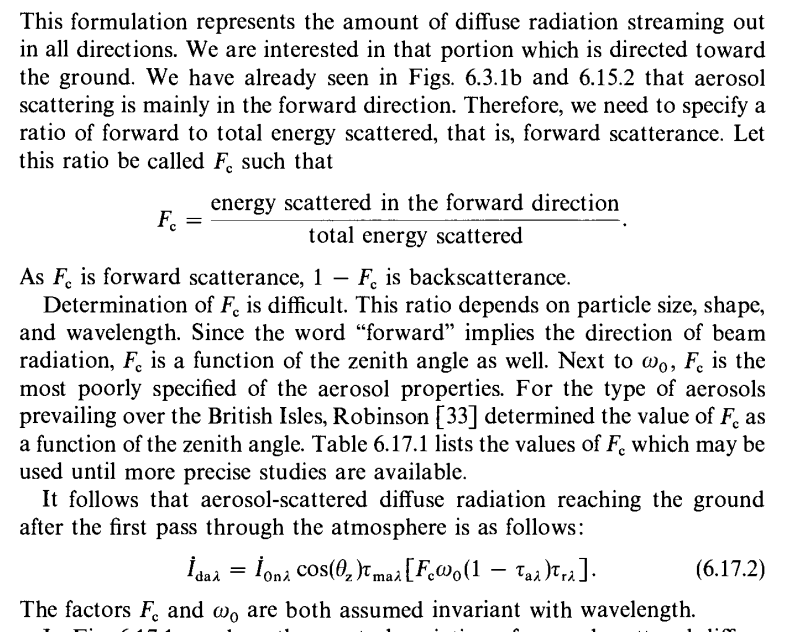

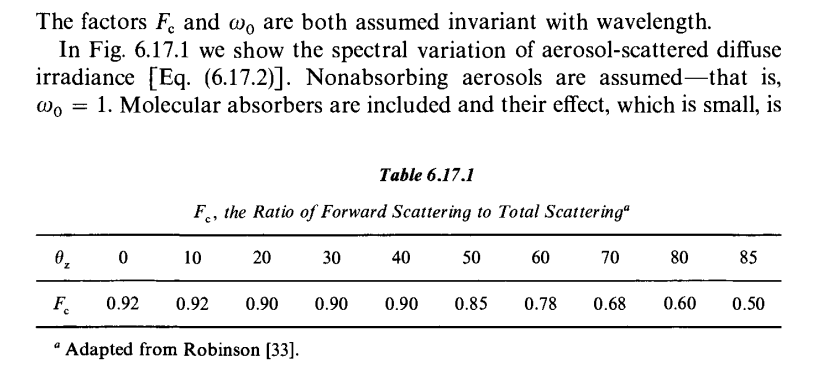

----
----

# **MODELO B**

In [19]:
#################
### MODELO B ####
#################

def absorcao_irrad_direta_gases_vapor_agua_B(U1):
    
    Aw = 0.110 * (U1 + 6.31 * 10**-4)**0.3 - 0.0121
    return Aw
    
def absorcao_irrad_direta_mistura_gases_B(ma):
    
    As = 0.00235 * (126 * ma + 0.0129)**0.26 - 7.5 * 10**-4 * ma**0.875
    return As
    
def absorcao_irrad_direta_ozonio_B(U3):
    
    Ao = 0.045 * (U3 + 8.34 * 10**-4)**0.38 - 3.1 * 10**-3
    return Ao
    
def absorcao_irrad_direta_aerosois_B(theta_as):
    
    Aa = (1 - 0.95) * theta_as
    return Aa

#def Aw_linha()

def Theta_as_B(ma):
    
    theta_as = (-0.914 + 1.909267 * math.exp(-0.667023 * 0.038)**ma)
    return theta_as

def Theta_r_B(ma):
    
    theta_r = 0.615958 + 0.375566 * (-0.221185 * ma).apply(math.exp)
    return theta_r

def Q_value(In, Z, I_dr, I_da):
    Q = In * Z.apply(cos) + I_dr + I_da
    return Q
    
def radiacao_direta_B(I_sc, Aw, As, Ao, Aa, theta_r, theta_as):
    
    In = I_sc * (1 - Aw + As + Ao + Aa) * theta_r * theta_as
    return In
    

#### IRRADIANCIA DIFUSA ######

def difusa_rayleigh_B(I_sc, Z, Aw, As, Ao, Aa, theta_r):
    
    I_dr = I_sc * Z.apply(cos) * (1 - Aw + As + Ao + Aa) * 0.5 * (1 - theta_r)
    return I_dr

def difusa_aerosois_B(I_sc, Z, Aw, As, Ao, Aa, theta_as):
    
    I_da = I_sc * Z.apply(cos) * (1 - Aw + As + Ao + Aa) * 0.75 * (1 - theta_as)
    return I_da

def difusa_espalhamento_multiplos_B(a, Q, Aw, As, Ao, Aa, theta_r, theta_as):
    
    I_dm = a * Q *(1 - Aw + As + Ao + Aa) * 0.5 * (1 - theta_r) + 0.25 * (1 - theta_as)
    return I_dm


### Criando os parâmetros

In [113]:
# MODELO B

def modelo_B(dataset, maximo):

    Aw_B = absorcao_irrad_direta_gases_vapor_agua_B(dataset['U1'])
    As_B = absorcao_irrad_direta_mistura_gases_B(dataset['ma'])
    Ao_B = absorcao_irrad_direta_ozonio_B(dataset['U3'])
    theta_as_B = Theta_as_B(dataset['ma'])
    Aa_B = absorcao_irrad_direta_aerosois_B(theta_as_B)
    theta_r_B = Theta_r_B(dataset['ma'])
    I_dr_B = difusa_rayleigh_B(dataset['I_sc'], dataset['Z'], Aw_B, As_B, Ao_B, Aa_B, theta_r_B)
    I_da_B = difusa_aerosois_B(dataset['I_sc'], dataset['Z'], Aw_B, As_B, Ao_B, Aa_B, theta_as_B)

    # Radiação Direta
    In_B = radiacao_direta_B(dataset['I_sc'], Aw_B, As_B, Ao_B, Aa_B, theta_r_B, theta_as_B)
    
    
    Q_B = Q_value(In_B, dataset['Z'], I_dr_B, I_da_B) 
    I_dm_B = difusa_espalhamento_multiplos_B(a, Q_B, Aw_B, As_B, Ao_B, Aa_B, theta_r_B, theta_as_B)

    # Radiacao Difusa
    I_d_B = I_dr_B + I_da_B + I_dm_B

    # Radiacao Global
    I_B = In_B * dataset['Z'].apply(math.cos) + I_d_B
    
    # Radiacao Difusa CosZ
    
    In_B_Z = In_B * dataset['Z'].apply(cos)
    
    In_B = remove_out(In_B.fillna(0), maximo)
    I_d_B = remove_out(I_d_B.fillna(0), maximo)
    I_B = remove_out(I_B.fillna(0), maximo)
    In_B_Z = remove_out(In_B_Z.fillna(0), maximo)

    
    return In_B, In_B_Z, I_d_B, I_B # Radiacao Direta, Radiacao Difusa, Radiacao Global

In [119]:
# MIAMI
RAD_DIRETA_SUMMER_MIAMI_B, RAD_DIRETA_COSZ_SUMMER_MIAMI_B,RAD_DIFUSA_SUMMER_MIAMI_B, RAD_GLOBAL_SUMMER_MIAMI_B = modelo_B(miami_summer, 1300)
RAD_DIRETA_WINTER_MIAMI_B, RAD_DIRETA_COSZ_WINTER_MIAMI_B,RAD_DIFUSA_WINTER_MIAMI_B, RAD_GLOBAL_WINTER_MIAMI_B = modelo_B(miami_winter, 1300)

In [120]:
miami_summer_models_b = output_models_csv(RAD_DIRETA_SUMMER_MIAMI_B, RAD_DIRETA_COSZ_SUMMER_MIAMI_B, RAD_DIFUSA_SUMMER_MIAMI_B, RAD_GLOBAL_SUMMER_MIAMI_B)
miami_winter_models_b = output_models_csv(RAD_DIRETA_WINTER_MIAMI_B, RAD_DIRETA_COSZ_WINTER_MIAMI_B, RAD_DIFUSA_WINTER_MIAMI_B, RAD_GLOBAL_WINTER_MIAMI_B)

In [121]:
miami_summer_models_b.to_clipboard(decimal=",", index=False)

In [122]:
miami_winter_models_b.to_clipboard(decimal=",", index=False)

In [125]:
# NEW YORK
# MIAMI
RAD_DIRETA_SUMMER_NY_B,RAD_DIRETA_COSZ_SUMMER_NY_B, RAD_DIFUSA_SUMMER_NY_B, RAD_GLOBAL_SUMMER_NY_B = modelo_B(ny_summer, 1300)
RAD_DIRETA_WINTER_NY_B,RAD_DIRETA_COSZ_WINTER_NY_B, RAD_DIFUSA_WINTER_NY_B, RAD_GLOBAL_WINTER_NY_B = modelo_B(ny_winter, 1300)

In [126]:
ny_summer_models_b = output_models_csv(RAD_DIRETA_SUMMER_NY_B,RAD_DIRETA_COSZ_SUMMER_NY_B, RAD_DIFUSA_SUMMER_NY_B, RAD_GLOBAL_SUMMER_NY_B)
ny_winter_models_b = output_models_csv(RAD_DIRETA_WINTER_NY_B,RAD_DIRETA_COSZ_WINTER_NY_B, RAD_DIFUSA_WINTER_NY_B, RAD_GLOBAL_WINTER_NY_B)

In [128]:
ny_summer_models_b.to_clipboard(decimal=",", index=False)

In [129]:
ny_winter_models_b.to_clipboard(decimal=",", index=False)

# **MODELO C**

In [95]:
#################
### MODELO C ####
#################

def radiacao_direta_C(I_sc, theta_r, theta_a, theta_o, theta_g, theta_w):
    
    In = 0.9751 * I_sc * theta_r * theta_a * theta_o * theta_g * theta_w
    return In

#theta_r
def transmitancia_rayleigh_C(ma):
    
    theta_r = ((-0.0903 * ma**0.84) * (1 + ma - ma**1.01)).apply(math.exp)
    return theta_r

#theta_o
def transmitancia_ozonio_C(Ao):
    
    theta_o = 1 - Ao
    return theta_o

# Ao
def Alpha_o(U3):
    
    alpha_o = 0.1611 * U3 * (1 + 139.48 * U3)**-0.3035 - 0.002715 * U3 * (1 + 0.044 * U3 + 0.0003 * U3**2)**-1
    return alpha_o

# theta_g
def transmitancia_gases_C(ma):
    
    theta_g = (-0.0127*ma**0.26).apply(math.exp)
    return theta_g

# theta_w
def transmitancia_vapor_agua_C(Aw):
    
    theta_w = 1 - Aw
    return theta_w

# Aw
def Alpha_w(U1):
    
    alpha_w = -2.4959 * U1 * ((1 + 79.034 * U1)**0.6828 + 6.385*U1)**-1
    return alpha_w

# theta_a
def transmitancia_aerosois_C(ka, ma):
    
    theta_a = ((-ka**0.873) * (1 + ka - ka**0.7088) * ma**0.9108).apply(math.exp)
    return theta_a


###################
# RADIACAO DIFUSA #
###################

# theta_aa
def transmitancia_radiacao_direta_C(Wo, ma, theta_a):
    
    theta_aa = 1 - (1 - Wo) * (1 - ma + ma**1.06) * (1 - theta_a)
    return theta_aa


def difusa_rayleigh_C(I_sc, Z, theta_w, theta_aa, theta_o, theta_g, theta_r, ma):

    I_dr = 0.79 * I_sc * Z.apply(cos) * theta_w * theta_g * theta_o * theta_aa * 0.5 * ( 1 - theta_r) / (1 - ma + ma**1.02)
    return I_dr

def difusa_aerosois_C(I_sc, Z, theta_w, theta_g, theta_o, theta_r, Aw, Fc, Wo, theta_a, theta_aa, ma):
    
    I_da = 0.79 * I_sc * Z.apply(cos) * theta_w * theta_g * theta_o * theta_aa * Fc * (1 - theta_a/theta_aa)/(1 - ma + ma**1.02)
    return I_da


def albedo_atmos_C(Fc, theta_a, theta_aa):
    
    rho_a = 0.0685 + (1 - Fc)*(1-(theta_a/theta_aa))
    return rho_a

def difusa_espalhamento_multiplo_C(In, Z, I_dr, I_da, rho_g, rho_a):
    
    I_dm = ((In * Z.apply(cos)  + I_dr + I_da) * rho_g * rho_a)/(1 - rho_g*rho_a)
    return I_dm


## Gerando Parâmetros Modelo C

In [97]:


def modelo_C(dataset, Wo, Fc, maximo):

    ka = 0.048 # 0.275(0.087) + 0.35(0.069) = 0.048  | Onde Kay(0.38) = 0.087 e kay(0.5) = 0.069,

    theta_r_C = transmitancia_rayleigh_C(dataset['ma'])
    Ao_C = Alpha_o(dataset['U3'])
    theta_o_C = transmitancia_ozonio_C(Ao_C)
    theta_g_C = transmitancia_gases_C(dataset['ma'])
    Aw_C = Alpha_w(dataset['U1'])
    theta_w_C = transmitancia_vapor_agua_C(Aw_C)
    theta_a_C = transmitancia_aerosois_C(ka, dataset['ma'])


    # RADIACAO DIRETA C
    In_C = radiacao_direta_C(dataset['I_sc'], theta_r_C, theta_a_C, theta_o_C, theta_g_C, theta_w_C)


    theta_aa_C = transmitancia_radiacao_direta_C(Wo, dataset['ma'], theta_a_C)
    I_dr_C = difusa_rayleigh_C(dataset['I_sc'], dataset['Z'], theta_w_C, theta_aa_C, theta_o_C, theta_g_C, theta_r_C, dataset['ma'])
    I_da_C = difusa_aerosois_C(dataset['I_sc'], dataset['Z'], theta_w_C, theta_g_C, theta_o_C, theta_r_C, Aw_C, Fc, Wo, theta_a_C, theta_aa_C, dataset['ma'])
    rho_a_C = albedo_atmos_C(Fc, theta_a_C, theta_aa_C)
    I_dm_C = difusa_espalhamento_multiplo_C(In_C, dataset['Z'], I_dr_C, I_da_C, dataset['Surface Albedo'], rho_a_C)

    # RADIACAO DIFUSA
    I_d_C = I_dr_C + I_da_C + I_dm_C

    # RADIACAO GLOBAL
    I_C = In_C * dataset['Z'].apply(cos) + I_d_C
    
    # RADIACAO DIRETA COS Z
    
    In_C_Z = In_C * dataset['Z'].apply(cos)
    
    In_C = remove_out(In_C.fillna(0), maximo)
    I_d_C = remove_out(I_d_C.fillna(0), maximo)
    I_C = remove_out(I_C.fillna(0), maximo)
    In_C_Z = remove_out(In_C_Z.fillna(0), maximo)
    
    return In_C, In_C_Z, I_d_C, I_C # Radiacao Direta, Radiacao Difusa, Radiacao Global

In [98]:
# MIAMI
RAD_DIRETA_SUMMER_MIAMI_C, RAD_DIRETA_Z_SUMMER_MIAMI_C, RAD_DIFUSA_SUMMER_MIAMI_C, RAD_GLOBAL_SUMMER_MIAMI_C = modelo_C(miami_summer, Wo, Fc, 1600)
RAD_DIRETA_WINTER_MIAMI_C, RAD_DIRETA_Z_WINTER_MIAMI_C, RAD_DIFUSA_WINTER_MIAMI_C, RAD_GLOBAL_WINTER_MIAMI_C = modelo_C(miami_winter, Wo, Fc, 3000)

In [99]:
miami_summer_models_c = output_models_csv(RAD_DIRETA_SUMMER_MIAMI_C, RAD_DIRETA_Z_SUMMER_MIAMI_C, RAD_DIFUSA_SUMMER_MIAMI_C, RAD_GLOBAL_SUMMER_MIAMI_C)
miami_winter_models_c = output_models_csv(RAD_DIRETA_WINTER_MIAMI_C, RAD_DIRETA_Z_WINTER_MIAMI_C, RAD_DIFUSA_WINTER_MIAMI_C, RAD_GLOBAL_WINTER_MIAMI_C)

In [100]:
miami_summer_models_c.to_clipboard(decimal=",", index=False)

In [152]:
miami_winter_models_c.to_clipboard(decimal=",", index=False)

In [ ]:
HORA	DIRETO	DIRETO_COSZ	DIFUSO	GLOBAL
0	0,0	0,0	0,0	0,0
1	0,0	0,0	0,0	0,0
2	0,0	0,0	0,0	0,0
3	0,0	0,0	0,0	0,0
4	0,0	0,0	0,0	0,0
5	0,0	0,0	0,0	0,0
6	0,0	0,0	0,0	0,0
7	408,04	24,48	48,22	72,7
8	899,65	234,21	106,17	340,38
9	1062,37	458,7	123,99	582,69
10	1131,93	636,89	132,84	769,73
11	1163,01	749,28	137,33	886,61
12	1171,45	785,67	138,64	924,31
13	1161,06	743,51	137,05	880,57
14	1127,66	626,16	132,28	758,44
15	1054,07	443,97	123,01	566,97
16	880,46	217,77	104,17	321,94
17	358,16	16,31	38,56	54,87
18	0,0	0,0	0,0	0,0
19	0,0	0,0	0,0	0,0
20	0,0	0,0	0,0	0,0
21	0,0	0,0	0,0	0,0
22	0,0	0,0	0,0	0,0
23	0,0	0,0	0,0	0,0


In [130]:
# NY
RAD_DIRETA_SUMMER_NY_C, RAD_DIRETA_COSZ_SUMMER_NY, RAD_DIFUSA_SUMMER_NY_C, RAD_GLOBAL_SUMMER_NY_C = modelo_C(ny_summer, Wo, Fc, 1600)
RAD_DIRETA_WINTER_NY_C, RAD_DIRETA_COSZ_WINTER_NY, RAD_DIFUSA_WINTER_NY_C, RAD_GLOBAL_WINTER_NY_C = modelo_C(ny_winter, Wo, Fc, 3000)

In [131]:
ny_summer_models_c = output_models_csv(RAD_DIRETA_SUMMER_NY_C, RAD_DIRETA_COSZ_SUMMER_NY, RAD_DIFUSA_SUMMER_NY_C, RAD_GLOBAL_SUMMER_NY_C)
ny_winter_models_c = output_models_csv(RAD_DIRETA_WINTER_NY_C, RAD_DIRETA_COSZ_WINTER_NY, RAD_DIFUSA_WINTER_NY_C, RAD_GLOBAL_WINTER_NY_C)

In [150]:
ny_summer_models_c.to_clipboard(decimal=",", index=False)

In [134]:
ny_winter_models_c.to_clipboard(decimal=",", index=False)

In [ ]:
HORA	DIRETO	DIRETO_COSZ	DIFUSO	GLOBAL
0	0,0	0,0	0,0	0,0
1	0,0	0,0	0,0	0,0
2	0,0	0,0	0,0	0,0
3	0,0	0,0	0,0	0,0
4	0,0	0,0	0,0	0,0
5	0,0	0,0	0,0	0,0
6	0,0	0,0	0,0	0,0
7	408,04	24,48	48,22	72,7
8	899,65	234,21	106,17	340,38
9	1062,37	458,7	123,99	582,69
10	1131,93	636,89	132,84	769,73
11	1163,01	749,28	137,33	886,61
12	1171,45	785,67	138,64	924,31
13	1161,06	743,51	137,05	880,57
14	1127,66	626,16	132,28	758,44
15	1054,07	443,97	123,01	566,97
16	880,46	217,77	104,17	321,94
17	358,16	16,31	38,56	54,87
18	0,0	0,0	0,0	0,0
19	0,0	0,0	0,0	0,0
20	0,0	0,0	0,0	0,0
21	0,0	0,0	0,0	0,0
22	0,0	0,0	0,0	0,0
23	0,0	0,0	0,0	0,0


# **Gerando estatísticas dos meses de Janeiro e Julho 2012** 

In [389]:
miami_winter_2012 = miami_2012[(miami_2012['date_time']>=datetime.datetime(2011,12,31,23,59)) & (miami_2012['date_time']<datetime.datetime(2012,2,1,0,0,0))]
ny_winter_2012 = ny_2012[(ny_2012['date_time']>=datetime.datetime(2011,12,31,23,59)) & (ny_2012['date_time']<datetime.datetime(2012,2,1,0,0,0))]

miami_summer_2012 = miami_2012[(miami_2012['date_time']>=datetime.datetime(2012,6,30,23,59)) & (miami_2012['date_time']<datetime.datetime(2012,8,1,0,0,0))]
ny_summer_2012 = ny_2012[(ny_2012['date_time']>=datetime.datetime(2012,6,30,23,59,0)) & (ny_2012['date_time']<datetime.datetime(2012,8,1,0,0,0))]

In [ ]:
miami_summer_2012['Hour'] = miami_summer_2012['Hour'].astype(str)
miami_winter_2012['Hour'] = miami_winter_2012['Hour'].astype(str)

ny_summer_2012['Hour'] = ny_summer_2012['Hour'].astype(str)
ny_winter_2012['Hour'] = ny_winter_2012['Hour'].astype(str)

In [434]:
mean_ny_winter = ny_winter_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].mean().round(5)
max_ny_winter = ny_winter_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].max().round(5)
min_ny_winter = ny_winter_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].min().round(5)

In [435]:
mean_ny_winter.index = mean_ny_winter.index.astype(int)
max_ny_winter.index = max_ny_winter.index.astype(int)
min_ny_winter.index = min_ny_winter.index.astype(int)

In [436]:
mean_ny_winter = mean_ny_winter.sort_values(by="Hour")
max_ny_winter = max_ny_winter.sort_values(by="Hour")
min_ny_winter = min_ny_winter.sort_values(by="Hour")

In [437]:
mean_ny_winter.to_clipboard(decimal=".", float_format='%.3f')

In [441]:
max_ny_winter.to_clipboard(decimal=".", float_format='%.3f')

In [446]:
min_ny_winter.to_clipboard(decimal=".", float_format='%.3f')

In [ ]:
# NY SUMMER

In [443]:
mean_ny_summer = ny_summer_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].mean().round(5)
max_ny_summer = ny_summer_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].max().round(5)
min_ny_summer = ny_summer_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].min().round(5)

mean_ny_summer.index = mean_ny_summer.index.astype(int)
max_ny_summer.index = max_ny_summer.index.astype(int)
min_ny_summer.index = min_ny_summer.index.astype(int)

mean_ny_summer = mean_ny_summer.sort_values(by="Hour")
max_ny_summer = max_ny_summer.sort_values(by="Hour")
min_ny_summer = min_ny_summer.sort_values(by="Hour")

In [447]:
mean_ny_summer.to_clipboard(decimal=".", float_format='%.3f')

In [448]:
max_ny_summer.to_clipboard(decimal=".", float_format='%.3f')

In [449]:
min_ny_summer.to_clipboard(decimal=".", float_format='%.3f')

In [ ]:
# MIAMI SUMMER

In [450]:
mean_miami_summer = miami_summer_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].mean()
max_miami_summer = miami_summer_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].max()
min_miami_summer = miami_summer_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].min()

In [451]:
mean_miami_summer.index = mean_miami_summer.index.astype(int)
max_miami_summer.index = max_miami_summer.index.astype(int)
min_miami_summer.index = min_miami_summer.index.astype(int)

In [452]:
mean_miami_summer = mean_miami_summer.sort_values(by="Hour")
max_miami_summer = max_miami_summer.sort_values(by="Hour")
min_miami_summer = min_miami_summer.sort_values(by="Hour")

In [454]:
mean_miami_summer.to_clipboard(decimal=".", float_format='%.3f')

In [455]:
max_miami_summer.to_clipboard(decimal=".", float_format='%.3f')

In [456]:
min_miami_summer.to_clipboard(decimal=".", float_format='%.3f')

In [457]:

# MIAMI WINTER
mean_miami_winter = miami_winter_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].mean()
max_miami_winter = miami_winter_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].max()
min_miami_winter = miami_winter_2012.groupby(by = "Hour")[['Clearsky DHI', 'Clearsky DNI','Clearsky GHI']].min()

mean_miami_winter.index = mean_miami_winter.index.astype(int)
max_miami_winter.index = max_miami_winter.index.astype(int)
min_miami_winter.index = min_miami_winter.index.astype(int)

mean_miami_winter = mean_miami_winter.sort_values(by="Hour")
max_miami_winter = max_miami_winter.sort_values(by="Hour")
min_miami_winter = min_miami_winter.sort_values(by="Hour")

In [458]:
mean_miami_winter.to_clipboard(decimal=".", float_format='%.3f')

In [459]:
max_miami_winter.to_clipboard(decimal=".", float_format='%.3f')

In [460]:
min_miami_winter.to_clipboard(decimal=".", float_format='%.3f')

In [40]:
RAD_DIRETA_SUMMER_MIAMI_C

4541       0.00
4542       0.00
4543       0.00
4544       0.00
4545       0.00
4546     253.21
4547     650.60
4548     901.62
4549    1006.04
4550    1059.61
4551    1088.89
4552    1103.68
4553    1107.87
4554    1102.45
4555    1086.11
4556    1054.46
4557     996.50
4558     881.41
4559     593.24
4560    1133.73
4561       0.00
4562       0.00
4563       0.00
4564       0.00
dtype: float64

In [39]:
HORA	DIRETO	DIFUSO	GLOBAL
0	0,0	0,0	0,0
1	0,0	0,0	0,0
2	0,0	0,0	0,0
3	0,0	0,0	0,0
4	0,0	0,0	0,0
5	312,65	0,0	0,0
6	772,02	92,64	230,67
7	1048,84	122,14	535,32
8	1158,08	136,25	823,48
9	1212,08	145,05	1070,83
10	1240,77	150,69	1259,06
11	1255,01	153,88	1375,24
12	1259,03	154,84	1411,35
13	1253,9	153,62	1364,96
14	1238,18	150,14	1239,09
15	1207,17	144,15	1042,52
16	1148,72	134,88	788,99
17	1027,8	119,72	496,91
18	707,66	85,84	192,51
19	1283,92	0,0	0,0
20	0,0	0,0	0,0
21	0,0	0,0	0,0
22	0,0	0,0	0,0
23	0,0	0,0	0,0


4541      0.00
4542      0.00
4543      0.00
4544      0.00
4545      0.00
4546      0.00
4547     92.16
4548    121.14
4549    134.84
4550    143.30
4551    148.71
4552    151.76
4553    152.68
4554    151.50
4555    148.18
4556    142.44
4557    133.51
4558    118.78
4559     85.43
4560      0.00
4561      0.00
4562      0.00
4563      0.00
4564      0.00
dtype: float64

In [38]:
RAD_GLOBAL_SUMMER_MIAMI_C

4541       0.00
4542       0.00
4543       0.00
4544       0.00
4545       0.00
4546       0.00
4547     208.49
4548     476.32
4549     731.84
4550     952.63
4551    1121.41
4552    1225.84
4553    1258.32
4554    1216.54
4555    1103.39
4556     927.17
4557     700.94
4558     442.24
4559     174.86
4560       0.00
4561       0.00
4562       0.00
4563       0.00
4564       0.00
dtype: float64

In [81]:
sin(0.523599)

0.5000001943375613

In [ ]:
HORA	DIRETO	DIFUSO	GLOBAL
0	0,0	0,0	0,0
1	0,0	0,0	0,0
2	0,0	0,0	0,0
3	0,0	0,0	0,0
4	0,0	0,0	0,0
5	312,65	0,0	0,0
6	772,02	92,64	230,67
7	1048,84	122,14	535,32
8	1158,08	136,25	823,48
9	1212,08	145,05	1070,83
10	1240,77	150,69	1259,06
11	1255,01	153,88	1375,24
12	1259,03	154,84	1411,35
13	1253,9	153,62	1364,96
14	1238,18	150,14	1239,09
15	1207,17	144,15	1042,52
16	1148,72	134,88	788,99
17	1027,8	119,72	496,91
18	707,66	85,84	192,51
19	1283,92	0,0	0,0
20	0,0	0,0	0,0
21	0,0	0,0	0,0
22	0,0	0,0	0,0
23	0,0	0,0	0,0
